In [32]:
import numpy as np
import collections

class Embedding(object):
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW = self.grads
        dW[...] = 0
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
        return None
    
    

class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

    
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


In [28]:
print(np.random.choice(10))
words = ['you', 'say', 'goodbye', 'I', 'hello']
print(np.random.choice(words))
p = [0.5, 0.1, 0.05, 0.2, 0.15]
print(np.random.choice(words, p=p))

2
I
you


In [29]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

    
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

In [30]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 2[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 3[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 4[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 5[s] | loss 3.91
| epoch 1 |  iter 121 / 9295 | time 5[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 6[s] | loss 3.64
| epoch 1 |  iter 161 / 9295 | time 7[s] | loss 3.48
| epoch 1 |  iter 181 / 9295 | time 8[s] | loss 3.35
| epoch 1 |  iter 201 / 9295 | time 9[s] | loss 3.25
| epoch 1 |  iter 221 / 9295 | time 10[s] | loss 3.18
| epoch 1 |  iter 241 / 9295 | time 11[s] | loss 3.08
| epoch 1 |  iter 261 / 9295 | time 12[s] | loss 3.03
| epoch 1 |  iter 281 / 9295 | time 13[s] | loss 2.98
| epoch 1 |  iter 301 / 9295 | time 14[s] | loss 2.90
| epoch 1 |  iter 321 / 9295 | time 15[s] | loss 2.87
| epoch 1 |  iter 341 / 9295 | time 16[s] | loss 2.85
| epoch 1 |  iter 361 / 9295 | time 17[s] | l

| epoch 1 |  iter 3001 / 9295 | time 143[s] | loss 2.46
| epoch 1 |  iter 3021 / 9295 | time 144[s] | loss 2.43
| epoch 1 |  iter 3041 / 9295 | time 145[s] | loss 2.47
| epoch 1 |  iter 3061 / 9295 | time 145[s] | loss 2.45
| epoch 1 |  iter 3081 / 9295 | time 146[s] | loss 2.50
| epoch 1 |  iter 3101 / 9295 | time 147[s] | loss 2.46
| epoch 1 |  iter 3121 / 9295 | time 148[s] | loss 2.47
| epoch 1 |  iter 3141 / 9295 | time 149[s] | loss 2.44
| epoch 1 |  iter 3161 / 9295 | time 150[s] | loss 2.45
| epoch 1 |  iter 3181 / 9295 | time 151[s] | loss 2.49
| epoch 1 |  iter 3201 / 9295 | time 152[s] | loss 2.46
| epoch 1 |  iter 3221 / 9295 | time 153[s] | loss 2.44
| epoch 1 |  iter 3241 / 9295 | time 154[s] | loss 2.45
| epoch 1 |  iter 3261 / 9295 | time 155[s] | loss 2.41
| epoch 1 |  iter 3281 / 9295 | time 156[s] | loss 2.44
| epoch 1 |  iter 3301 / 9295 | time 157[s] | loss 2.44
| epoch 1 |  iter 3321 / 9295 | time 158[s] | loss 2.43
| epoch 1 |  iter 3341 / 9295 | time 159[s] | lo

| epoch 1 |  iter 5941 / 9295 | time 287[s] | loss 2.34
| epoch 1 |  iter 5961 / 9295 | time 288[s] | loss 2.33
| epoch 1 |  iter 5981 / 9295 | time 289[s] | loss 2.29
| epoch 1 |  iter 6001 / 9295 | time 290[s] | loss 2.35
| epoch 1 |  iter 6021 / 9295 | time 291[s] | loss 2.30
| epoch 1 |  iter 6041 / 9295 | time 292[s] | loss 2.34
| epoch 1 |  iter 6061 / 9295 | time 293[s] | loss 2.30
| epoch 1 |  iter 6081 / 9295 | time 294[s] | loss 2.31
| epoch 1 |  iter 6101 / 9295 | time 294[s] | loss 2.34
| epoch 1 |  iter 6121 / 9295 | time 295[s] | loss 2.31
| epoch 1 |  iter 6141 / 9295 | time 296[s] | loss 2.35
| epoch 1 |  iter 6161 / 9295 | time 297[s] | loss 2.32
| epoch 1 |  iter 6181 / 9295 | time 298[s] | loss 2.29
| epoch 1 |  iter 6201 / 9295 | time 299[s] | loss 2.28
| epoch 1 |  iter 6221 / 9295 | time 300[s] | loss 2.29
| epoch 1 |  iter 6241 / 9295 | time 301[s] | loss 2.33
| epoch 1 |  iter 6261 / 9295 | time 302[s] | loss 2.32
| epoch 1 |  iter 6281 / 9295 | time 303[s] | lo

| epoch 1 |  iter 8881 / 9295 | time 426[s] | loss 2.21
| epoch 1 |  iter 8901 / 9295 | time 427[s] | loss 2.20
| epoch 1 |  iter 8921 / 9295 | time 428[s] | loss 2.23
| epoch 1 |  iter 8941 / 9295 | time 429[s] | loss 2.22
| epoch 1 |  iter 8961 / 9295 | time 430[s] | loss 2.23
| epoch 1 |  iter 8981 / 9295 | time 431[s] | loss 2.23
| epoch 1 |  iter 9001 / 9295 | time 432[s] | loss 2.22
| epoch 1 |  iter 9021 / 9295 | time 433[s] | loss 2.19
| epoch 1 |  iter 9041 / 9295 | time 434[s] | loss 2.19
| epoch 1 |  iter 9061 / 9295 | time 435[s] | loss 2.21
| epoch 1 |  iter 9081 / 9295 | time 436[s] | loss 2.23
| epoch 1 |  iter 9101 / 9295 | time 437[s] | loss 2.22
| epoch 1 |  iter 9121 / 9295 | time 438[s] | loss 2.23
| epoch 1 |  iter 9141 / 9295 | time 438[s] | loss 2.22
| epoch 1 |  iter 9161 / 9295 | time 439[s] | loss 2.22
| epoch 1 |  iter 9181 / 9295 | time 440[s] | loss 2.21
| epoch 1 |  iter 9201 / 9295 | time 441[s] | loss 2.22
| epoch 1 |  iter 9221 / 9295 | time 442[s] | lo

| epoch 2 |  iter 2541 / 9295 | time 567[s] | loss 2.11
| epoch 2 |  iter 2561 / 9295 | time 568[s] | loss 2.13
| epoch 2 |  iter 2581 / 9295 | time 569[s] | loss 2.13
| epoch 2 |  iter 2601 / 9295 | time 570[s] | loss 2.12
| epoch 2 |  iter 2621 / 9295 | time 571[s] | loss 2.12
| epoch 2 |  iter 2641 / 9295 | time 572[s] | loss 2.12
| epoch 2 |  iter 2661 / 9295 | time 573[s] | loss 2.12
| epoch 2 |  iter 2681 / 9295 | time 574[s] | loss 2.17
| epoch 2 |  iter 2701 / 9295 | time 575[s] | loss 2.16
| epoch 2 |  iter 2721 / 9295 | time 576[s] | loss 2.11
| epoch 2 |  iter 2741 / 9295 | time 577[s] | loss 2.12
| epoch 2 |  iter 2761 / 9295 | time 578[s] | loss 2.12
| epoch 2 |  iter 2781 / 9295 | time 579[s] | loss 2.09
| epoch 2 |  iter 2801 / 9295 | time 580[s] | loss 2.09
| epoch 2 |  iter 2821 / 9295 | time 581[s] | loss 2.06
| epoch 2 |  iter 2841 / 9295 | time 582[s] | loss 2.14
| epoch 2 |  iter 2861 / 9295 | time 583[s] | loss 2.11
| epoch 2 |  iter 2881 / 9295 | time 584[s] | lo

| epoch 2 |  iter 5481 / 9295 | time 708[s] | loss 2.06
| epoch 2 |  iter 5501 / 9295 | time 709[s] | loss 2.01
| epoch 2 |  iter 5521 / 9295 | time 710[s] | loss 2.07
| epoch 2 |  iter 5541 / 9295 | time 711[s] | loss 2.08
| epoch 2 |  iter 5561 / 9295 | time 712[s] | loss 2.09
| epoch 2 |  iter 5581 / 9295 | time 713[s] | loss 2.06
| epoch 2 |  iter 5601 / 9295 | time 714[s] | loss 2.07
| epoch 2 |  iter 5621 / 9295 | time 715[s] | loss 2.07
| epoch 2 |  iter 5641 / 9295 | time 716[s] | loss 2.07
| epoch 2 |  iter 5661 / 9295 | time 717[s] | loss 2.07
| epoch 2 |  iter 5681 / 9295 | time 718[s] | loss 2.08
| epoch 2 |  iter 5701 / 9295 | time 719[s] | loss 2.06
| epoch 2 |  iter 5721 / 9295 | time 720[s] | loss 2.04
| epoch 2 |  iter 5741 / 9295 | time 721[s] | loss 2.04
| epoch 2 |  iter 5761 / 9295 | time 722[s] | loss 2.03
| epoch 2 |  iter 5781 / 9295 | time 723[s] | loss 2.06
| epoch 2 |  iter 5801 / 9295 | time 724[s] | loss 2.06
| epoch 2 |  iter 5821 / 9295 | time 724[s] | lo

| epoch 2 |  iter 8421 / 9295 | time 849[s] | loss 2.06
| epoch 2 |  iter 8441 / 9295 | time 850[s] | loss 2.01
| epoch 2 |  iter 8461 / 9295 | time 851[s] | loss 2.04
| epoch 2 |  iter 8481 / 9295 | time 852[s] | loss 2.03
| epoch 2 |  iter 8501 / 9295 | time 853[s] | loss 1.99
| epoch 2 |  iter 8521 / 9295 | time 854[s] | loss 2.01
| epoch 2 |  iter 8541 / 9295 | time 855[s] | loss 1.99
| epoch 2 |  iter 8561 / 9295 | time 856[s] | loss 2.02
| epoch 2 |  iter 8581 / 9295 | time 857[s] | loss 2.04
| epoch 2 |  iter 8601 / 9295 | time 858[s] | loss 2.05
| epoch 2 |  iter 8621 / 9295 | time 859[s] | loss 2.02
| epoch 2 |  iter 8641 / 9295 | time 860[s] | loss 2.00
| epoch 2 |  iter 8661 / 9295 | time 861[s] | loss 2.02
| epoch 2 |  iter 8681 / 9295 | time 862[s] | loss 2.04
| epoch 2 |  iter 8701 / 9295 | time 863[s] | loss 2.03
| epoch 2 |  iter 8721 / 9295 | time 864[s] | loss 2.01
| epoch 2 |  iter 8741 / 9295 | time 865[s] | loss 2.05
| epoch 2 |  iter 8761 / 9295 | time 866[s] | lo

| epoch 3 |  iter 2081 / 9295 | time 992[s] | loss 1.92
| epoch 3 |  iter 2101 / 9295 | time 992[s] | loss 1.94
| epoch 3 |  iter 2121 / 9295 | time 993[s] | loss 1.94
| epoch 3 |  iter 2141 / 9295 | time 994[s] | loss 1.93
| epoch 3 |  iter 2161 / 9295 | time 995[s] | loss 1.93
| epoch 3 |  iter 2181 / 9295 | time 996[s] | loss 1.95
| epoch 3 |  iter 2201 / 9295 | time 997[s] | loss 1.93
| epoch 3 |  iter 2221 / 9295 | time 998[s] | loss 1.91
| epoch 3 |  iter 2241 / 9295 | time 999[s] | loss 1.93
| epoch 3 |  iter 2261 / 9295 | time 1000[s] | loss 1.96
| epoch 3 |  iter 2281 / 9295 | time 1001[s] | loss 1.96
| epoch 3 |  iter 2301 / 9295 | time 1002[s] | loss 1.98
| epoch 3 |  iter 2321 / 9295 | time 1003[s] | loss 1.95
| epoch 3 |  iter 2341 / 9295 | time 1004[s] | loss 1.93
| epoch 3 |  iter 2361 / 9295 | time 1005[s] | loss 1.95
| epoch 3 |  iter 2381 / 9295 | time 1006[s] | loss 1.93
| epoch 3 |  iter 2401 / 9295 | time 1007[s] | loss 1.93
| epoch 3 |  iter 2421 / 9295 | time 100

| epoch 3 |  iter 4961 / 9295 | time 1127[s] | loss 1.91
| epoch 3 |  iter 4981 / 9295 | time 1128[s] | loss 1.89
| epoch 3 |  iter 5001 / 9295 | time 1129[s] | loss 1.92
| epoch 3 |  iter 5021 / 9295 | time 1130[s] | loss 1.95
| epoch 3 |  iter 5041 / 9295 | time 1131[s] | loss 1.92
| epoch 3 |  iter 5061 / 9295 | time 1132[s] | loss 1.90
| epoch 3 |  iter 5081 / 9295 | time 1133[s] | loss 1.91
| epoch 3 |  iter 5101 / 9295 | time 1134[s] | loss 1.90
| epoch 3 |  iter 5121 / 9295 | time 1135[s] | loss 1.91
| epoch 3 |  iter 5141 / 9295 | time 1135[s] | loss 1.89
| epoch 3 |  iter 5161 / 9295 | time 1136[s] | loss 1.90
| epoch 3 |  iter 5181 / 9295 | time 1137[s] | loss 1.89
| epoch 3 |  iter 5201 / 9295 | time 1138[s] | loss 1.95
| epoch 3 |  iter 5221 / 9295 | time 1139[s] | loss 1.92
| epoch 3 |  iter 5241 / 9295 | time 1140[s] | loss 1.91
| epoch 3 |  iter 5261 / 9295 | time 1141[s] | loss 1.90
| epoch 3 |  iter 5281 / 9295 | time 1142[s] | loss 1.91
| epoch 3 |  iter 5301 / 9295 |

| epoch 3 |  iter 7841 / 9295 | time 1262[s] | loss 1.90
| epoch 3 |  iter 7861 / 9295 | time 1263[s] | loss 1.90
| epoch 3 |  iter 7881 / 9295 | time 1264[s] | loss 1.89
| epoch 3 |  iter 7901 / 9295 | time 1264[s] | loss 1.91
| epoch 3 |  iter 7921 / 9295 | time 1265[s] | loss 1.92
| epoch 3 |  iter 7941 / 9295 | time 1266[s] | loss 1.90
| epoch 3 |  iter 7961 / 9295 | time 1267[s] | loss 1.86
| epoch 3 |  iter 7981 / 9295 | time 1268[s] | loss 1.92
| epoch 3 |  iter 8001 / 9295 | time 1269[s] | loss 1.89
| epoch 3 |  iter 8021 / 9295 | time 1270[s] | loss 1.91
| epoch 3 |  iter 8041 / 9295 | time 1271[s] | loss 1.88
| epoch 3 |  iter 8061 / 9295 | time 1272[s] | loss 1.88
| epoch 3 |  iter 8081 / 9295 | time 1273[s] | loss 1.91
| epoch 3 |  iter 8101 / 9295 | time 1274[s] | loss 1.90
| epoch 3 |  iter 8121 / 9295 | time 1275[s] | loss 1.89
| epoch 3 |  iter 8141 / 9295 | time 1276[s] | loss 1.91
| epoch 3 |  iter 8161 / 9295 | time 1277[s] | loss 1.88
| epoch 3 |  iter 8181 / 9295 |

| epoch 4 |  iter 1441 / 9295 | time 1398[s] | loss 1.83
| epoch 4 |  iter 1461 / 9295 | time 1398[s] | loss 1.83
| epoch 4 |  iter 1481 / 9295 | time 1399[s] | loss 1.79
| epoch 4 |  iter 1501 / 9295 | time 1400[s] | loss 1.82
| epoch 4 |  iter 1521 / 9295 | time 1401[s] | loss 1.83
| epoch 4 |  iter 1541 / 9295 | time 1402[s] | loss 1.83
| epoch 4 |  iter 1561 / 9295 | time 1403[s] | loss 1.79
| epoch 4 |  iter 1581 / 9295 | time 1404[s] | loss 1.85
| epoch 4 |  iter 1601 / 9295 | time 1405[s] | loss 1.79
| epoch 4 |  iter 1621 / 9295 | time 1406[s] | loss 1.84
| epoch 4 |  iter 1641 / 9295 | time 1407[s] | loss 1.82
| epoch 4 |  iter 1661 / 9295 | time 1408[s] | loss 1.78
| epoch 4 |  iter 1681 / 9295 | time 1409[s] | loss 1.81
| epoch 4 |  iter 1701 / 9295 | time 1410[s] | loss 1.81
| epoch 4 |  iter 1721 / 9295 | time 1410[s] | loss 1.83
| epoch 4 |  iter 1741 / 9295 | time 1411[s] | loss 1.83
| epoch 4 |  iter 1761 / 9295 | time 1412[s] | loss 1.85
| epoch 4 |  iter 1781 / 9295 |

| epoch 4 |  iter 4321 / 9295 | time 1532[s] | loss 1.81
| epoch 4 |  iter 4341 / 9295 | time 1533[s] | loss 1.81
| epoch 4 |  iter 4361 / 9295 | time 1534[s] | loss 1.84
| epoch 4 |  iter 4381 / 9295 | time 1535[s] | loss 1.82
| epoch 4 |  iter 4401 / 9295 | time 1535[s] | loss 1.82
| epoch 4 |  iter 4421 / 9295 | time 1536[s] | loss 1.85
| epoch 4 |  iter 4441 / 9295 | time 1537[s] | loss 1.83
| epoch 4 |  iter 4461 / 9295 | time 1538[s] | loss 1.79
| epoch 4 |  iter 4481 / 9295 | time 1539[s] | loss 1.81
| epoch 4 |  iter 4501 / 9295 | time 1540[s] | loss 1.79
| epoch 4 |  iter 4521 / 9295 | time 1541[s] | loss 1.80
| epoch 4 |  iter 4541 / 9295 | time 1542[s] | loss 1.81
| epoch 4 |  iter 4561 / 9295 | time 1543[s] | loss 1.78
| epoch 4 |  iter 4581 / 9295 | time 1544[s] | loss 1.80
| epoch 4 |  iter 4601 / 9295 | time 1545[s] | loss 1.78
| epoch 4 |  iter 4621 / 9295 | time 1546[s] | loss 1.80
| epoch 4 |  iter 4641 / 9295 | time 1547[s] | loss 1.84
| epoch 4 |  iter 4661 / 9295 |

| epoch 4 |  iter 7201 / 9295 | time 1669[s] | loss 1.79
| epoch 4 |  iter 7221 / 9295 | time 1670[s] | loss 1.85
| epoch 4 |  iter 7241 / 9295 | time 1671[s] | loss 1.78
| epoch 4 |  iter 7261 / 9295 | time 1672[s] | loss 1.81
| epoch 4 |  iter 7281 / 9295 | time 1672[s] | loss 1.80
| epoch 4 |  iter 7301 / 9295 | time 1673[s] | loss 1.80
| epoch 4 |  iter 7321 / 9295 | time 1674[s] | loss 1.82
| epoch 4 |  iter 7341 / 9295 | time 1675[s] | loss 1.80
| epoch 4 |  iter 7361 / 9295 | time 1676[s] | loss 1.82
| epoch 4 |  iter 7381 / 9295 | time 1677[s] | loss 1.75
| epoch 4 |  iter 7401 / 9295 | time 1678[s] | loss 1.84
| epoch 4 |  iter 7421 / 9295 | time 1679[s] | loss 1.83
| epoch 4 |  iter 7441 / 9295 | time 1680[s] | loss 1.79
| epoch 4 |  iter 7461 / 9295 | time 1681[s] | loss 1.78
| epoch 4 |  iter 7481 / 9295 | time 1682[s] | loss 1.82
| epoch 4 |  iter 7501 / 9295 | time 1683[s] | loss 1.84
| epoch 4 |  iter 7521 / 9295 | time 1684[s] | loss 1.80
| epoch 4 |  iter 7541 / 9295 |

| epoch 5 |  iter 801 / 9295 | time 1802[s] | loss 1.71
| epoch 5 |  iter 821 / 9295 | time 1803[s] | loss 1.70
| epoch 5 |  iter 841 / 9295 | time 1804[s] | loss 1.74
| epoch 5 |  iter 861 / 9295 | time 1805[s] | loss 1.69
| epoch 5 |  iter 881 / 9295 | time 1806[s] | loss 1.70
| epoch 5 |  iter 901 / 9295 | time 1806[s] | loss 1.75
| epoch 5 |  iter 921 / 9295 | time 1807[s] | loss 1.69
| epoch 5 |  iter 941 / 9295 | time 1808[s] | loss 1.70
| epoch 5 |  iter 961 / 9295 | time 1809[s] | loss 1.69
| epoch 5 |  iter 981 / 9295 | time 1810[s] | loss 1.73
| epoch 5 |  iter 1001 / 9295 | time 1811[s] | loss 1.73
| epoch 5 |  iter 1021 / 9295 | time 1812[s] | loss 1.70
| epoch 5 |  iter 1041 / 9295 | time 1813[s] | loss 1.70
| epoch 5 |  iter 1061 / 9295 | time 1814[s] | loss 1.72
| epoch 5 |  iter 1081 / 9295 | time 1815[s] | loss 1.71
| epoch 5 |  iter 1101 / 9295 | time 1816[s] | loss 1.69
| epoch 5 |  iter 1121 / 9295 | time 1817[s] | loss 1.68
| epoch 5 |  iter 1141 / 9295 | time 1818

| epoch 5 |  iter 3681 / 9295 | time 1935[s] | loss 1.72
| epoch 5 |  iter 3701 / 9295 | time 1936[s] | loss 1.75
| epoch 5 |  iter 3721 / 9295 | time 1937[s] | loss 1.74
| epoch 5 |  iter 3741 / 9295 | time 1938[s] | loss 1.73
| epoch 5 |  iter 3761 / 9295 | time 1939[s] | loss 1.72
| epoch 5 |  iter 3781 / 9295 | time 1940[s] | loss 1.73
| epoch 5 |  iter 3801 / 9295 | time 1941[s] | loss 1.70
| epoch 5 |  iter 3821 / 9295 | time 1941[s] | loss 1.68
| epoch 5 |  iter 3841 / 9295 | time 1942[s] | loss 1.71
| epoch 5 |  iter 3861 / 9295 | time 1943[s] | loss 1.74
| epoch 5 |  iter 3881 / 9295 | time 1944[s] | loss 1.70
| epoch 5 |  iter 3901 / 9295 | time 1945[s] | loss 1.69
| epoch 5 |  iter 3921 / 9295 | time 1946[s] | loss 1.73
| epoch 5 |  iter 3941 / 9295 | time 1947[s] | loss 1.75
| epoch 5 |  iter 3961 / 9295 | time 1948[s] | loss 1.70
| epoch 5 |  iter 3981 / 9295 | time 1949[s] | loss 1.72
| epoch 5 |  iter 4001 / 9295 | time 1950[s] | loss 1.73
| epoch 5 |  iter 4021 / 9295 |

| epoch 5 |  iter 6561 / 9295 | time 2066[s] | loss 1.69
| epoch 5 |  iter 6581 / 9295 | time 2067[s] | loss 1.70
| epoch 5 |  iter 6601 / 9295 | time 2068[s] | loss 1.71
| epoch 5 |  iter 6621 / 9295 | time 2069[s] | loss 1.71
| epoch 5 |  iter 6641 / 9295 | time 2070[s] | loss 1.72
| epoch 5 |  iter 6661 / 9295 | time 2071[s] | loss 1.75
| epoch 5 |  iter 6681 / 9295 | time 2072[s] | loss 1.72
| epoch 5 |  iter 6701 / 9295 | time 2073[s] | loss 1.70
| epoch 5 |  iter 6721 / 9295 | time 2074[s] | loss 1.69
| epoch 5 |  iter 6741 / 9295 | time 2075[s] | loss 1.77
| epoch 5 |  iter 6761 / 9295 | time 2075[s] | loss 1.71
| epoch 5 |  iter 6781 / 9295 | time 2076[s] | loss 1.72
| epoch 5 |  iter 6801 / 9295 | time 2077[s] | loss 1.68
| epoch 5 |  iter 6821 / 9295 | time 2078[s] | loss 1.71
| epoch 5 |  iter 6841 / 9295 | time 2079[s] | loss 1.73
| epoch 5 |  iter 6861 / 9295 | time 2080[s] | loss 1.69
| epoch 5 |  iter 6881 / 9295 | time 2081[s] | loss 1.74
| epoch 5 |  iter 6901 / 9295 |

| epoch 6 |  iter 141 / 9295 | time 2197[s] | loss 1.64
| epoch 6 |  iter 161 / 9295 | time 2198[s] | loss 1.66
| epoch 6 |  iter 181 / 9295 | time 2199[s] | loss 1.62
| epoch 6 |  iter 201 / 9295 | time 2200[s] | loss 1.67
| epoch 6 |  iter 221 / 9295 | time 2201[s] | loss 1.64
| epoch 6 |  iter 241 / 9295 | time 2202[s] | loss 1.65
| epoch 6 |  iter 261 / 9295 | time 2203[s] | loss 1.63
| epoch 6 |  iter 281 / 9295 | time 2204[s] | loss 1.61
| epoch 6 |  iter 301 / 9295 | time 2205[s] | loss 1.63
| epoch 6 |  iter 321 / 9295 | time 2205[s] | loss 1.66
| epoch 6 |  iter 341 / 9295 | time 2206[s] | loss 1.60
| epoch 6 |  iter 361 / 9295 | time 2207[s] | loss 1.60
| epoch 6 |  iter 381 / 9295 | time 2208[s] | loss 1.65
| epoch 6 |  iter 401 / 9295 | time 2209[s] | loss 1.64
| epoch 6 |  iter 421 / 9295 | time 2210[s] | loss 1.60
| epoch 6 |  iter 441 / 9295 | time 2211[s] | loss 1.64
| epoch 6 |  iter 461 / 9295 | time 2212[s] | loss 1.63
| epoch 6 |  iter 481 / 9295 | time 2213[s] | lo

| epoch 6 |  iter 3041 / 9295 | time 2472[s] | loss 1.68
| epoch 6 |  iter 3061 / 9295 | time 2473[s] | loss 1.67
| epoch 6 |  iter 3081 / 9295 | time 2474[s] | loss 1.64
| epoch 6 |  iter 3101 / 9295 | time 2475[s] | loss 1.63
| epoch 6 |  iter 3121 / 9295 | time 2476[s] | loss 1.66
| epoch 6 |  iter 3141 / 9295 | time 2477[s] | loss 1.63
| epoch 6 |  iter 3161 / 9295 | time 2478[s] | loss 1.63
| epoch 6 |  iter 3181 / 9295 | time 2479[s] | loss 1.60
| epoch 6 |  iter 3201 / 9295 | time 2480[s] | loss 1.69
| epoch 6 |  iter 3221 / 9295 | time 2481[s] | loss 1.69
| epoch 6 |  iter 3241 / 9295 | time 2482[s] | loss 1.65
| epoch 6 |  iter 3261 / 9295 | time 2483[s] | loss 1.64
| epoch 6 |  iter 3281 / 9295 | time 2484[s] | loss 1.64
| epoch 6 |  iter 3301 / 9295 | time 2485[s] | loss 1.66
| epoch 6 |  iter 3321 / 9295 | time 2486[s] | loss 1.68
| epoch 6 |  iter 3341 / 9295 | time 2487[s] | loss 1.62
| epoch 6 |  iter 3361 / 9295 | time 2488[s] | loss 1.63
| epoch 6 |  iter 3381 / 9295 |

| epoch 6 |  iter 5921 / 9295 | time 2628[s] | loss 1.66
| epoch 6 |  iter 5941 / 9295 | time 2629[s] | loss 1.64
| epoch 6 |  iter 5961 / 9295 | time 2630[s] | loss 1.68
| epoch 6 |  iter 5981 / 9295 | time 2631[s] | loss 1.64
| epoch 6 |  iter 6001 / 9295 | time 2632[s] | loss 1.63
| epoch 6 |  iter 6021 / 9295 | time 2632[s] | loss 1.69
| epoch 6 |  iter 6041 / 9295 | time 2633[s] | loss 1.62
| epoch 6 |  iter 6061 / 9295 | time 2634[s] | loss 1.66
| epoch 6 |  iter 6081 / 9295 | time 2635[s] | loss 1.62
| epoch 6 |  iter 6101 / 9295 | time 2636[s] | loss 1.64
| epoch 6 |  iter 6121 / 9295 | time 2637[s] | loss 1.68
| epoch 6 |  iter 6141 / 9295 | time 2638[s] | loss 1.66
| epoch 6 |  iter 6161 / 9295 | time 2639[s] | loss 1.63
| epoch 6 |  iter 6181 / 9295 | time 2640[s] | loss 1.66
| epoch 6 |  iter 6201 / 9295 | time 2641[s] | loss 1.68
| epoch 6 |  iter 6221 / 9295 | time 2642[s] | loss 1.60
| epoch 6 |  iter 6241 / 9295 | time 2643[s] | loss 1.65
| epoch 6 |  iter 6261 / 9295 |

| epoch 6 |  iter 8801 / 9295 | time 2774[s] | loss 1.64
| epoch 6 |  iter 8821 / 9295 | time 2775[s] | loss 1.64
| epoch 6 |  iter 8841 / 9295 | time 2776[s] | loss 1.64
| epoch 6 |  iter 8861 / 9295 | time 2777[s] | loss 1.65
| epoch 6 |  iter 8881 / 9295 | time 2778[s] | loss 1.59
| epoch 6 |  iter 8901 / 9295 | time 2779[s] | loss 1.66
| epoch 6 |  iter 8921 / 9295 | time 2780[s] | loss 1.63
| epoch 6 |  iter 8941 / 9295 | time 2781[s] | loss 1.64
| epoch 6 |  iter 8961 / 9295 | time 2782[s] | loss 1.64
| epoch 6 |  iter 8981 / 9295 | time 2783[s] | loss 1.61
| epoch 6 |  iter 9001 / 9295 | time 2784[s] | loss 1.63
| epoch 6 |  iter 9021 / 9295 | time 2785[s] | loss 1.67
| epoch 6 |  iter 9041 / 9295 | time 2786[s] | loss 1.63
| epoch 6 |  iter 9061 / 9295 | time 2787[s] | loss 1.72
| epoch 6 |  iter 9081 / 9295 | time 2788[s] | loss 1.65
| epoch 6 |  iter 9101 / 9295 | time 2789[s] | loss 1.66
| epoch 6 |  iter 9121 / 9295 | time 2790[s] | loss 1.66
| epoch 6 |  iter 9141 / 9295 |

| epoch 7 |  iter 2401 / 9295 | time 2933[s] | loss 1.60
| epoch 7 |  iter 2421 / 9295 | time 2934[s] | loss 1.62
| epoch 7 |  iter 2441 / 9295 | time 2935[s] | loss 1.60
| epoch 7 |  iter 2461 / 9295 | time 2936[s] | loss 1.54
| epoch 7 |  iter 2481 / 9295 | time 2938[s] | loss 1.58
| epoch 7 |  iter 2501 / 9295 | time 2939[s] | loss 1.58
| epoch 7 |  iter 2521 / 9295 | time 2940[s] | loss 1.61
| epoch 7 |  iter 2541 / 9295 | time 2941[s] | loss 1.55
| epoch 7 |  iter 2561 / 9295 | time 2942[s] | loss 1.55
| epoch 7 |  iter 2581 / 9295 | time 2943[s] | loss 1.56
| epoch 7 |  iter 2601 / 9295 | time 2944[s] | loss 1.60
| epoch 7 |  iter 2621 / 9295 | time 2945[s] | loss 1.55
| epoch 7 |  iter 2641 / 9295 | time 2947[s] | loss 1.59
| epoch 7 |  iter 2661 / 9295 | time 2948[s] | loss 1.57
| epoch 7 |  iter 2681 / 9295 | time 2949[s] | loss 1.61
| epoch 7 |  iter 2701 / 9295 | time 2950[s] | loss 1.56
| epoch 7 |  iter 2721 / 9295 | time 2951[s] | loss 1.58
| epoch 7 |  iter 2741 / 9295 |

| epoch 7 |  iter 5281 / 9295 | time 3103[s] | loss 1.60
| epoch 7 |  iter 5301 / 9295 | time 3105[s] | loss 1.58
| epoch 7 |  iter 5321 / 9295 | time 3106[s] | loss 1.58
| epoch 7 |  iter 5341 / 9295 | time 3107[s] | loss 1.56
| epoch 7 |  iter 5361 / 9295 | time 3108[s] | loss 1.59
| epoch 7 |  iter 5381 / 9295 | time 3109[s] | loss 1.60
| epoch 7 |  iter 5401 / 9295 | time 3110[s] | loss 1.59
| epoch 7 |  iter 5421 / 9295 | time 3111[s] | loss 1.54
| epoch 7 |  iter 5441 / 9295 | time 3112[s] | loss 1.59
| epoch 7 |  iter 5461 / 9295 | time 3114[s] | loss 1.58
| epoch 7 |  iter 5481 / 9295 | time 3115[s] | loss 1.63
| epoch 7 |  iter 5501 / 9295 | time 3116[s] | loss 1.58
| epoch 7 |  iter 5521 / 9295 | time 3117[s] | loss 1.59
| epoch 7 |  iter 5541 / 9295 | time 3119[s] | loss 1.60
| epoch 7 |  iter 5561 / 9295 | time 3120[s] | loss 1.58
| epoch 7 |  iter 5581 / 9295 | time 3121[s] | loss 1.58
| epoch 7 |  iter 5601 / 9295 | time 3122[s] | loss 1.58
| epoch 7 |  iter 5621 / 9295 |

| epoch 7 |  iter 8161 / 9295 | time 3269[s] | loss 1.61
| epoch 7 |  iter 8181 / 9295 | time 3270[s] | loss 1.59
| epoch 7 |  iter 8201 / 9295 | time 3271[s] | loss 1.56
| epoch 7 |  iter 8221 / 9295 | time 3273[s] | loss 1.61
| epoch 7 |  iter 8241 / 9295 | time 3274[s] | loss 1.59
| epoch 7 |  iter 8261 / 9295 | time 3275[s] | loss 1.57
| epoch 7 |  iter 8281 / 9295 | time 3277[s] | loss 1.58
| epoch 7 |  iter 8301 / 9295 | time 3278[s] | loss 1.59
| epoch 7 |  iter 8321 / 9295 | time 3279[s] | loss 1.62
| epoch 7 |  iter 8341 / 9295 | time 3281[s] | loss 1.58
| epoch 7 |  iter 8361 / 9295 | time 3282[s] | loss 1.58
| epoch 7 |  iter 8381 / 9295 | time 3283[s] | loss 1.56
| epoch 7 |  iter 8401 / 9295 | time 3285[s] | loss 1.59
| epoch 7 |  iter 8421 / 9295 | time 3286[s] | loss 1.57
| epoch 7 |  iter 8441 / 9295 | time 3287[s] | loss 1.54
| epoch 7 |  iter 8461 / 9295 | time 3288[s] | loss 1.61
| epoch 7 |  iter 8481 / 9295 | time 3289[s] | loss 1.62
| epoch 7 |  iter 8501 / 9295 |

| epoch 8 |  iter 1761 / 9295 | time 3441[s] | loss 1.51
| epoch 8 |  iter 1781 / 9295 | time 3443[s] | loss 1.54
| epoch 8 |  iter 1801 / 9295 | time 3444[s] | loss 1.51
| epoch 8 |  iter 1821 / 9295 | time 3445[s] | loss 1.53
| epoch 8 |  iter 1841 / 9295 | time 3446[s] | loss 1.54
| epoch 8 |  iter 1861 / 9295 | time 3447[s] | loss 1.54
| epoch 8 |  iter 1881 / 9295 | time 3449[s] | loss 1.53
| epoch 8 |  iter 1901 / 9295 | time 3450[s] | loss 1.54
| epoch 8 |  iter 1921 / 9295 | time 3451[s] | loss 1.50
| epoch 8 |  iter 1941 / 9295 | time 3452[s] | loss 1.52
| epoch 8 |  iter 1961 / 9295 | time 3453[s] | loss 1.55
| epoch 8 |  iter 1981 / 9295 | time 3455[s] | loss 1.51
| epoch 8 |  iter 2001 / 9295 | time 3456[s] | loss 1.53
| epoch 8 |  iter 2021 / 9295 | time 3457[s] | loss 1.52
| epoch 8 |  iter 2041 / 9295 | time 3458[s] | loss 1.51
| epoch 8 |  iter 2061 / 9295 | time 3459[s] | loss 1.51
| epoch 8 |  iter 2081 / 9295 | time 3460[s] | loss 1.53
| epoch 8 |  iter 2101 / 9295 |

| epoch 8 |  iter 4641 / 9295 | time 3606[s] | loss 1.56
| epoch 8 |  iter 4661 / 9295 | time 3608[s] | loss 1.53
| epoch 8 |  iter 4681 / 9295 | time 3609[s] | loss 1.56
| epoch 8 |  iter 4701 / 9295 | time 3610[s] | loss 1.55
| epoch 8 |  iter 4721 / 9295 | time 3612[s] | loss 1.55
| epoch 8 |  iter 4741 / 9295 | time 3613[s] | loss 1.52
| epoch 8 |  iter 4761 / 9295 | time 3614[s] | loss 1.52
| epoch 8 |  iter 4781 / 9295 | time 3615[s] | loss 1.53
| epoch 8 |  iter 4801 / 9295 | time 3617[s] | loss 1.55
| epoch 8 |  iter 4821 / 9295 | time 3618[s] | loss 1.50
| epoch 8 |  iter 4841 / 9295 | time 3619[s] | loss 1.52
| epoch 8 |  iter 4861 / 9295 | time 3620[s] | loss 1.54
| epoch 8 |  iter 4881 / 9295 | time 3621[s] | loss 1.56
| epoch 8 |  iter 4901 / 9295 | time 3622[s] | loss 1.59
| epoch 8 |  iter 4921 / 9295 | time 3624[s] | loss 1.52
| epoch 8 |  iter 4941 / 9295 | time 3625[s] | loss 1.54
| epoch 8 |  iter 4961 / 9295 | time 3626[s] | loss 1.49
| epoch 8 |  iter 4981 / 9295 |

| epoch 8 |  iter 7521 / 9295 | time 3768[s] | loss 1.55
| epoch 8 |  iter 7541 / 9295 | time 3770[s] | loss 1.58
| epoch 8 |  iter 7561 / 9295 | time 3771[s] | loss 1.56
| epoch 8 |  iter 7581 / 9295 | time 3772[s] | loss 1.53
| epoch 8 |  iter 7601 / 9295 | time 3773[s] | loss 1.55
| epoch 8 |  iter 7621 / 9295 | time 3774[s] | loss 1.51
| epoch 8 |  iter 7641 / 9295 | time 3775[s] | loss 1.52
| epoch 8 |  iter 7661 / 9295 | time 3776[s] | loss 1.52
| epoch 8 |  iter 7681 / 9295 | time 3777[s] | loss 1.56
| epoch 8 |  iter 7701 / 9295 | time 3778[s] | loss 1.54
| epoch 8 |  iter 7721 / 9295 | time 3779[s] | loss 1.58
| epoch 8 |  iter 7741 / 9295 | time 3780[s] | loss 1.53
| epoch 8 |  iter 7761 / 9295 | time 3781[s] | loss 1.51
| epoch 8 |  iter 7781 / 9295 | time 3783[s] | loss 1.53
| epoch 8 |  iter 7801 / 9295 | time 3784[s] | loss 1.54
| epoch 8 |  iter 7821 / 9295 | time 3785[s] | loss 1.54
| epoch 8 |  iter 7841 / 9295 | time 3786[s] | loss 1.51
| epoch 8 |  iter 7861 / 9295 |

| epoch 9 |  iter 1121 / 9295 | time 3927[s] | loss 1.45
| epoch 9 |  iter 1141 / 9295 | time 3928[s] | loss 1.46
| epoch 9 |  iter 1161 / 9295 | time 3929[s] | loss 1.45
| epoch 9 |  iter 1181 / 9295 | time 3930[s] | loss 1.48
| epoch 9 |  iter 1201 / 9295 | time 3931[s] | loss 1.46
| epoch 9 |  iter 1221 / 9295 | time 3933[s] | loss 1.47
| epoch 9 |  iter 1241 / 9295 | time 3934[s] | loss 1.50
| epoch 9 |  iter 1261 / 9295 | time 3935[s] | loss 1.45
| epoch 9 |  iter 1281 / 9295 | time 3937[s] | loss 1.49
| epoch 9 |  iter 1301 / 9295 | time 3939[s] | loss 1.51
| epoch 9 |  iter 1321 / 9295 | time 3940[s] | loss 1.48
| epoch 9 |  iter 1341 / 9295 | time 3941[s] | loss 1.49
| epoch 9 |  iter 1361 / 9295 | time 3943[s] | loss 1.50
| epoch 9 |  iter 1381 / 9295 | time 3944[s] | loss 1.50
| epoch 9 |  iter 1401 / 9295 | time 3945[s] | loss 1.47
| epoch 9 |  iter 1421 / 9295 | time 3946[s] | loss 1.47
| epoch 9 |  iter 1441 / 9295 | time 3947[s] | loss 1.46
| epoch 9 |  iter 1461 / 9295 |

| epoch 9 |  iter 4001 / 9295 | time 4088[s] | loss 1.46
| epoch 9 |  iter 4021 / 9295 | time 4089[s] | loss 1.48
| epoch 9 |  iter 4041 / 9295 | time 4090[s] | loss 1.47
| epoch 9 |  iter 4061 / 9295 | time 4091[s] | loss 1.48
| epoch 9 |  iter 4081 / 9295 | time 4092[s] | loss 1.53
| epoch 9 |  iter 4101 / 9295 | time 4093[s] | loss 1.52
| epoch 9 |  iter 4121 / 9295 | time 4094[s] | loss 1.49
| epoch 9 |  iter 4141 / 9295 | time 4095[s] | loss 1.47
| epoch 9 |  iter 4161 / 9295 | time 4096[s] | loss 1.46
| epoch 9 |  iter 4181 / 9295 | time 4097[s] | loss 1.53
| epoch 9 |  iter 4201 / 9295 | time 4098[s] | loss 1.53
| epoch 9 |  iter 4221 / 9295 | time 4099[s] | loss 1.49
| epoch 9 |  iter 4241 / 9295 | time 4100[s] | loss 1.47
| epoch 9 |  iter 4261 / 9295 | time 4101[s] | loss 1.49
| epoch 9 |  iter 4281 / 9295 | time 4102[s] | loss 1.47
| epoch 9 |  iter 4301 / 9295 | time 4103[s] | loss 1.52
| epoch 9 |  iter 4321 / 9295 | time 4104[s] | loss 1.43
| epoch 9 |  iter 4341 / 9295 |

| epoch 9 |  iter 6881 / 9295 | time 4239[s] | loss 1.51
| epoch 9 |  iter 6901 / 9295 | time 4240[s] | loss 1.48
| epoch 9 |  iter 6921 / 9295 | time 4241[s] | loss 1.48
| epoch 9 |  iter 6941 / 9295 | time 4242[s] | loss 1.47
| epoch 9 |  iter 6961 / 9295 | time 4243[s] | loss 1.49
| epoch 9 |  iter 6981 / 9295 | time 4244[s] | loss 1.50
| epoch 9 |  iter 7001 / 9295 | time 4245[s] | loss 1.48
| epoch 9 |  iter 7021 / 9295 | time 4246[s] | loss 1.49
| epoch 9 |  iter 7041 / 9295 | time 4247[s] | loss 1.44
| epoch 9 |  iter 7061 / 9295 | time 4248[s] | loss 1.46
| epoch 9 |  iter 7081 / 9295 | time 4249[s] | loss 1.46
| epoch 9 |  iter 7101 / 9295 | time 4250[s] | loss 1.50
| epoch 9 |  iter 7121 / 9295 | time 4251[s] | loss 1.46
| epoch 9 |  iter 7141 / 9295 | time 4252[s] | loss 1.48
| epoch 9 |  iter 7161 / 9295 | time 4253[s] | loss 1.53
| epoch 9 |  iter 7181 / 9295 | time 4254[s] | loss 1.54
| epoch 9 |  iter 7201 / 9295 | time 4255[s] | loss 1.47
| epoch 9 |  iter 7221 / 9295 |

| epoch 10 |  iter 461 / 9295 | time 4386[s] | loss 1.42
| epoch 10 |  iter 481 / 9295 | time 4387[s] | loss 1.44
| epoch 10 |  iter 501 / 9295 | time 4388[s] | loss 1.44
| epoch 10 |  iter 521 / 9295 | time 4389[s] | loss 1.40
| epoch 10 |  iter 541 / 9295 | time 4390[s] | loss 1.39
| epoch 10 |  iter 561 / 9295 | time 4391[s] | loss 1.43
| epoch 10 |  iter 581 / 9295 | time 4391[s] | loss 1.42
| epoch 10 |  iter 601 / 9295 | time 4392[s] | loss 1.48
| epoch 10 |  iter 621 / 9295 | time 4393[s] | loss 1.41
| epoch 10 |  iter 641 / 9295 | time 4394[s] | loss 1.40
| epoch 10 |  iter 661 / 9295 | time 4395[s] | loss 1.42
| epoch 10 |  iter 681 / 9295 | time 4396[s] | loss 1.42
| epoch 10 |  iter 701 / 9295 | time 4397[s] | loss 1.42
| epoch 10 |  iter 721 / 9295 | time 4398[s] | loss 1.43
| epoch 10 |  iter 741 / 9295 | time 4399[s] | loss 1.44
| epoch 10 |  iter 761 / 9295 | time 4400[s] | loss 1.43
| epoch 10 |  iter 781 / 9295 | time 4401[s] | loss 1.44
| epoch 10 |  iter 801 / 9295 |

| epoch 10 |  iter 3301 / 9295 | time 4524[s] | loss 1.38
| epoch 10 |  iter 3321 / 9295 | time 4525[s] | loss 1.42
| epoch 10 |  iter 3341 / 9295 | time 4526[s] | loss 1.42
| epoch 10 |  iter 3361 / 9295 | time 4527[s] | loss 1.44
| epoch 10 |  iter 3381 / 9295 | time 4528[s] | loss 1.42
| epoch 10 |  iter 3401 / 9295 | time 4529[s] | loss 1.45
| epoch 10 |  iter 3421 / 9295 | time 4529[s] | loss 1.44
| epoch 10 |  iter 3441 / 9295 | time 4530[s] | loss 1.50
| epoch 10 |  iter 3461 / 9295 | time 4531[s] | loss 1.46
| epoch 10 |  iter 3481 / 9295 | time 4532[s] | loss 1.40
| epoch 10 |  iter 3501 / 9295 | time 4533[s] | loss 1.41
| epoch 10 |  iter 3521 / 9295 | time 4534[s] | loss 1.45
| epoch 10 |  iter 3541 / 9295 | time 4535[s] | loss 1.44
| epoch 10 |  iter 3561 / 9295 | time 4536[s] | loss 1.46
| epoch 10 |  iter 3581 / 9295 | time 4537[s] | loss 1.45
| epoch 10 |  iter 3601 / 9295 | time 4538[s] | loss 1.42
| epoch 10 |  iter 3621 / 9295 | time 4539[s] | loss 1.41
| epoch 10 |  

| epoch 10 |  iter 6141 / 9295 | time 4662[s] | loss 1.41
| epoch 10 |  iter 6161 / 9295 | time 4663[s] | loss 1.43
| epoch 10 |  iter 6181 / 9295 | time 4664[s] | loss 1.45
| epoch 10 |  iter 6201 / 9295 | time 4665[s] | loss 1.47
| epoch 10 |  iter 6221 / 9295 | time 4666[s] | loss 1.40
| epoch 10 |  iter 6241 / 9295 | time 4667[s] | loss 1.46
| epoch 10 |  iter 6261 / 9295 | time 4668[s] | loss 1.46
| epoch 10 |  iter 6281 / 9295 | time 4669[s] | loss 1.43
| epoch 10 |  iter 6301 / 9295 | time 4670[s] | loss 1.41
| epoch 10 |  iter 6321 / 9295 | time 4671[s] | loss 1.47
| epoch 10 |  iter 6341 / 9295 | time 4672[s] | loss 1.47
| epoch 10 |  iter 6361 / 9295 | time 4673[s] | loss 1.45
| epoch 10 |  iter 6381 / 9295 | time 4674[s] | loss 1.46
| epoch 10 |  iter 6401 / 9295 | time 4675[s] | loss 1.48
| epoch 10 |  iter 6421 / 9295 | time 4676[s] | loss 1.46
| epoch 10 |  iter 6441 / 9295 | time 4677[s] | loss 1.46
| epoch 10 |  iter 6461 / 9295 | time 4678[s] | loss 1.46
| epoch 10 |  

| epoch 10 |  iter 8981 / 9295 | time 4800[s] | loss 1.47
| epoch 10 |  iter 9001 / 9295 | time 4801[s] | loss 1.45
| epoch 10 |  iter 9021 / 9295 | time 4802[s] | loss 1.45
| epoch 10 |  iter 9041 / 9295 | time 4803[s] | loss 1.46
| epoch 10 |  iter 9061 / 9295 | time 4804[s] | loss 1.47
| epoch 10 |  iter 9081 / 9295 | time 4805[s] | loss 1.46
| epoch 10 |  iter 9101 / 9295 | time 4806[s] | loss 1.47
| epoch 10 |  iter 9121 / 9295 | time 4807[s] | loss 1.47
| epoch 10 |  iter 9141 / 9295 | time 4808[s] | loss 1.47
| epoch 10 |  iter 9161 / 9295 | time 4809[s] | loss 1.46
| epoch 10 |  iter 9181 / 9295 | time 4810[s] | loss 1.49
| epoch 10 |  iter 9201 / 9295 | time 4811[s] | loss 1.43
| epoch 10 |  iter 9221 / 9295 | time 4812[s] | loss 1.49
| epoch 10 |  iter 9241 / 9295 | time 4812[s] | loss 1.43
| epoch 10 |  iter 9261 / 9295 | time 4813[s] | loss 1.46
| epoch 10 |  iter 9281 / 9295 | time 4814[s] | loss 1.48


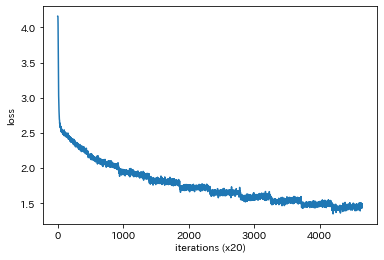

In [46]:
import sys
sys.path.append('..')
sys.path.append('../author_code/ch04/')
from common import config
# GPUで実行する場合は、下記のコメントアウトを消去（要cupy）
# ===============================================
# config.GPU = True
# ===============================================
from common.np import *
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from author_code.ch04.skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


In [47]:
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# most similar task
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# analogy task
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you
 we: 0.71484375
 i: 0.68603515625
 your: 0.64404296875
 someone: 0.60888671875
 they: 0.58837890625

[query] year
 month: 0.85986328125
 week: 0.78857421875
 spring: 0.77490234375
 summer: 0.77001953125
 decade: 0.669921875

[query] car
 auto: 0.60693359375
 luxury: 0.60595703125
 window: 0.595703125
 merkur: 0.54345703125
 cars: 0.53466796875

[query] toyota
 weyerhaeuser: 0.6474609375
 engines: 0.640625
 motor: 0.62939453125
 nissan: 0.625
 honda: 0.61865234375
--------------------------------------------------

[analogy] king:man = queen:?
 a.m: 5.8359375
 woman: 4.9140625
 downside: 4.5234375
 lucky: 4.51953125
 fbi: 4.51171875

[analogy] take:took = go:?
 're: 4.6171875
 went: 4.2734375
 came: 4.05859375
 eurodollars: 3.775390625
 goes: 3.744140625

[analogy] car:cars = child:?
 a.m: 7.12890625
 rape: 5.515625
 children: 5.359375
 daffynition: 4.94140625
 bond-equivalent: 4.83203125

[analogy] good:better = bad:?
 rather: 5.50390625
 more: 5.375
 less: 5.30859375
 gre

In [49]:
analogy('egg', 'chicken', 'baby',  word_to_id, id_to_word, word_vecs)


[analogy] egg:chicken = baby:?
 contributed: 4.2265625
 ambassador: 4.0859375
 consultant: 4.04296875
 pricings: 4.0390625
 referred: 3.94921875
